In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import cv2
import math
import random
import keras
from sklearn import preprocessing

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "x.npy")
LABELS_FILE = os.path.join(POET_DIR, "y.npy")
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [3]:
%pwd

'D:\\data\\POETdataset'

# LOAD DATA

How to access dictionaries in numpy data : use `tolist()`

In [4]:
x = np.load(PATCHES_FILE).tolist()

In [5]:
y = np.load(LABELS_FILE).tolist()

In [6]:
class2idx = np.load(CLASS2IDX_FILE).tolist()

In [7]:
idx2class = np.load(IDX2CLASS_FILE).tolist()

## CHECKING DATA

In [8]:
len(x)

4491

In [9]:
len(y)

6270

In [10]:
x['cat_2009_002527'].shape

(3, 1, 512)

In [11]:
y['cat_2009_002527']

3

In [12]:
idx2class[3]

'cat'

In [13]:
class2idx['cat']

3

# DATA EXPLORATION

## IMBALANCED DATASET

(array([ 666.,  536.,  504., 1051.,  301.,  498., 1257.,  480.,  510.,
         467.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

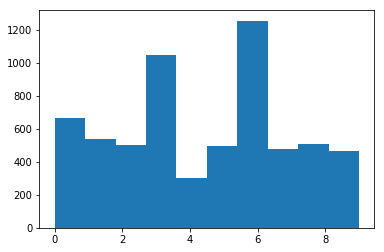

In [14]:
plt.hist(y.values(),bins=len(idx2class))

## Xtrain, Ytrain

In [15]:
xtrain = np.array(list(x.values()))

In [16]:
xtrain = xtrain[:,:,0,:]

In [17]:
assert xtrain.shape[1:] == (3, 512)

In [18]:
ytrain = np.array([y[k] for k in list(x.keys())])


In [19]:
len(ytrain), len(xtrain)

(4491, 4491)

## ONE HOT ENCODER

In [20]:
from sklearn.preprocessing import OneHotEncoder


In [21]:
enc = OneHotEncoder(handle_unknown='ignore')

In [22]:
ytrain = ytrain.reshape((-1,1))

In [23]:
enc.fit(ytrain)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [24]:
ytrain = enc.transform(ytrain)

In [25]:
ytrain[22].argmax()

9

### CHECKING

In [26]:
idx2class[ytrain[22].argmax()]

'sofa'

In [27]:
list(x.items())[22]

('sofa_2009_000217',
 array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],
 
        [[47.79278  ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],
 
        [[ 1.4062679,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]], dtype=float32))

In [28]:
idx2class[ytrain[2122].argmax()]

'horse'

In [29]:
list(x.items())[2122]

('horse_2009_003530', array([[[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]]], dtype=float32))

# MODEL TRAINING

## MODEL DEFINITION

In [30]:
def get_model():
  model = keras.Sequential()
  model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
#   model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
  model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))


  model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
  print(model.summary())
  return model

In [31]:
filepath="weights-2_64layers_32-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [32]:
model = get_model()
model.fit(
  xtrain,
  ytrain,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=20,
  callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 148,362
Trainable params: 148,362
Non-trainable params: 0
_________________________________________________________________
None
Train on 3592 samples, validate on 899 samples
Epoch 1/20
 - 4s - loss: 2.1667 - acc: 0.2102 - val_loss: 2.0275 - val_acc: 0.2659

Epoch 00001: val_acc improved from -inf to 0.26585, saving model to weights-2_64layers_32-01-0.27.hdf5
Epoch 2/20
 - 1s - loss: 1.9388 - acc: 0.2645 - val_loss: 1.8653 - val_acc: 0.3192

Epoch 00002: val_acc improved from 0.26585 to 0.31924, saving model to weights-2_64layers_32-02-0.32.hdf5
Epoch 3/20
 - 1s - loss: 1.8066 - acc: 0.3388 - val_loss: 1.7976 - val_acc: 0.3560

Epoch 00003: val_ac

## BALANCED CLASSES

In [33]:
y = np.load(LABELS_FILE).tolist()
ytrain = np.array([y[k] for k in list(x.keys())])

In [34]:
from scipy import stats

In [35]:
stats.itemfreq(ytrain)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[  0, 283],
       [  1, 417],
       [  2, 346],
       [  3, 810],
       [  4, 219],
       [  5, 422],
       [  6, 944],
       [  7, 334],
       [  8, 349],
       [  9, 367]], dtype=int64)

In [36]:
MIN_CLASS = 219

In [37]:
xtrain_bal = np.zeros((MIN_CLASS*10, MAX_GAZE_POINTS, VGG_NR_FEATURES))
ytrain_bal = np.zeros((MIN_CLASS*10))
counts = {k:0 for k in idx2class.keys()}

In [38]:
i = 0
for ins_k, ins_v in x.items():
  class_of_ins = y[ins_k]
  if counts[class_of_ins] < MIN_CLASS:
    xtrain_bal[i] = ins_v[:,0,:]
    ytrain_bal[i] = class_of_ins
    counts[class_of_ins] += 1
    i+=1


In [39]:
stats.itemfreq(ytrain_bal)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[  0., 219.],
       [  1., 219.],
       [  2., 219.],
       [  3., 219.],
       [  4., 219.],
       [  5., 219.],
       [  6., 219.],
       [  7., 219.],
       [  8., 219.],
       [  9., 219.]])

## MODEL

In [40]:
enc = OneHotEncoder(handle_unknown='ignore')

In [41]:
ytrain_bal = ytrain_bal.reshape((-1,1))

In [42]:
enc.fit(ytrain_bal)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [43]:
ytrain_bal = enc.transform(ytrain_bal)

In [44]:
ytrain_bal[22].argmax()

9

In [45]:
def get_model():
  model = keras.Sequential()
  model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
#   model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
  model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))


  model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  print(model.summary())
  return model

In [46]:
filepath="bal_weights_adadelta-64layers-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [47]:
model = get_model()
model.fit(
  xtrain_bal,
  ytrain_bal,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=50,
  callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 148,362
Trainable params: 148,362
Non-trainable params: 0
_________________________________________________________________
None
Train on 1752 samples, validate on 438 samples
Epoch 1/50
 - 2s - loss: 2.3000 - acc: 0.1250 - val_loss: 2.2965 - val_acc: 0.1438

Epoch 00001: val_acc improved from -inf to 0.14384, saving model to bal_weights_adadelta-64layers-01-0.14.hdf5
Epoch 2/50
 - 1s - loss: 2.2067 - acc: 0.2163 - val_loss: 2.2802 - val_acc: 0.1484

Epoch 00002: val_acc improved from 0.14384 to 0.14840, saving model to bal_weights_adadelta-64layers-02-0.15.hdf5
Epoch 3/50
 - 1s - loss: 2.1239 - acc: 0.2626 - val_loss: 2.2491 - val_acc: 0.1598

Epo